# Finance Lab 3

## Import libraries

In [1]:
!pip install plotly_express

In [2]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import plotly_express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from collections import defaultdict, Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from transformers import pipeline
from bs4 import BeautifulSoup
import requests
import re
import statsmodels.api as sm

### Colab Only - Drive folder

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Finance/'

## Task 1

### Load Data

In [3]:
# import the data in two separate dataframes
if 'path' in globals():
    stocks_data = pd.read_csv(f'{path}Data_PCLab1_Stock.csv')
    tweets_data = pd.read_csv(f'{path}Data_PCLab3_Twitter_Stock_Sentiment.csv')
else:
    stocks_data = pd.read_csv('Data_PCLab1_Stock.csv')
    tweets_data = pd.read_csv('Data_PCLab3_Twitter_Stock_Sentiment.csv')

### Dataset Shape

In [4]:
# we inspect the tweets data
print(tweets_data.shape)
display(tweets_data.head())
print(f'The dataset contains {tweets_data.shape[0]} tweets')

(5791, 2)


,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


The dataset contains 5791 tweets


### Data Overview

In [5]:
tweets_data['tweet_length'] = tweets_data['Text'].apply(lambda x: len(x)) # we compute the number of characters for each tweet, spaces included
tweets_data['tweet_n_words'] = tweets_data['Text'].apply(lambda x: len(x.split())) # we compute the number of words for each tweet

In [6]:
tweets_data.head() # inspect the changed dataset

,Text,Sentiment,tweet_length,tweet_n_words
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,95,20
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,95,16
2,user I'd be afraid to short AMZN - they are lo...,1,114,18
3,MNTA Over 12.00,1,17,3
4,OI Over 21.37,1,16,3


In [7]:
# scrape the list of tickers, we will need them later!
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
wiki_page = requests.get(url).content
soup = BeautifulSoup(wiki_page, 'html.parser')
tics = soup.find_all('td')
wiki_tickers = [tic.find('a', attrs = {'class' : 'external text'}).text for tic in tics if tic.find('a', attrs = {'class' : 'external text'})]

In [8]:
fig = ff.create_distplot([tweets_data['tweet_length']], group_labels=['Tweet Length (chars)'], colors=['blue']) # we plot the distribution of characters per tweet
fig.add_vline(tweets_data['tweet_length'].mean(), annotation_text='Mean',
              line_dash = 'dash' , annotation_position='top right', line_color = 'red') # add a dashed line corresponding to the mean
fig.update_layout(title_text='Distribution of Tweet Lengths (chars)')
fig.show()

print('Mean tweet length (chars):', round(tweets_data['tweet_length'].mean(), 2))

Mean tweet length (chars): 78.51


The lengths of tweets by character do not seem to follow a well-defined distribution. From the plot it can be inferred that users tend to write shorter tweets, although longer ones are still present and relevant. A noticeable spike occurs at around 140 characters, which can be traced back to the old Twitter's limit of characters per post.

In [9]:
fig = ff.create_distplot([tweets_data['tweet_n_words']], group_labels=['Tweet Length (words)'], colors=['blue']) # we plot the number of words per tweet
fig.add_vline(tweets_data['tweet_n_words'].mean(), annotation_text='Mean',
              line_dash = 'dash' , annotation_position='top right', line_color = 'red') #add a dashed line corresponding to the mean
fig.update_layout(title_text='Distribution of Tweet Lengths (words)')
fig.show()
print('Mean tweet length (words):', tweets_data['tweet_n_words'].mean())

Mean tweet length (words): 14.008806769124504


Unlike the previous plot, the distribution of tweet lengths by words appears to follow a more defined unimodal pattern, with a slight right skew. This suggests, once again, that users tend to use fewer words when tweeting about financial assets. This distribution, however, is based on the raw text of the tweets. A further analysis with lemmatized and cleaned text may provide additional information.

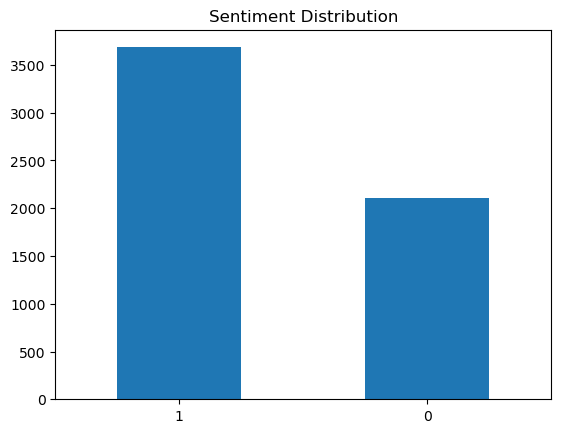

In [10]:
# we plot the distribution of sentiment across all tweets
tweets_data['Sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.xticks(rotation=0)
plt.show()

It appears that tweets with positive sentiment are almost double in number as those with a negative one. It must be noted, however, that the labels are binary, meaning that there is no "neutral" sentiment category. The previous plot may thus be deceiving, as tweets which could be considered as neutral are forcibly categorized as either positive or negative.

Logically speaking, the lack of a "neutral" label may be problematic. By considering Twitter as a source of objective news and statements, it can be argued that some tweets regarding financial assets simply provide information on the market's state. Categorizing those types  of tweets as expressing a polarized sentiment may therefore be misleading.

## Task 2

### Text Cleaning

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cicci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This way we only keep alphanumeric words. Further exploration will determine wether it is preferable to remove short words (for example in this sentence "AI" would be lost). The usage of the tokenizer before removing non-alaphanumeric charchters should help with the correct splitting of the words and the punctuation handling.

In [12]:
# apply our stratrgy to clean the text column
tweets_data['Text'] = tweets_data['Text'].astype(str) # convert the text column to string
tokenizer = TweetTokenizer()
stop_words = set(stopwords.words('english')) # save stopwords in a list
stop_words -= {'over'}
# we clean the text column
tweets_data['Cleaned Text'] = tweets_data['Text'].apply(lambda x: [word.lower() for word in tokenizer.tokenize(x.strip())])
tweets_data['Cleaned Text'] = tweets_data['Cleaned Text'].apply(lambda x: [re.sub(r'\W', ' ', word) for word in x]) # remove special characters
tweets_data['Cleaned Text'] = tweets_data['Cleaned Text'].apply(lambda x: [word for word in x if word.lower() not in stop_words and word.isalnum()
                                                                   and (len(word) >= 3 or word.upper() in wiki_tickers)]) # lowercase, remove stopwords, remove non-alphanumeric words, keep only words with 3 or more characters
# tweets_data['Cleaned Text'] = tweets_data['Cleaned Text'].apply(lambda x: ['aapl' if word == 'aap' else word for word in x]) # substitute 'aap' with 'aapl'

display(tweets_data.head()) # inspect the data

,Text,Sentiment,tweet_length,tweet_n_words,Cleaned Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,95,20,"[kickers, watchlist, xide, tit, soq, pnk, cpw,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,95,16,"[user, aap, movie, return, fea, geed, indicato..."
2,user I'd be afraid to short AMZN - they are lo...,1,114,18,"[user, afraid, short, amzn, looking, like, ebo..."
3,MNTA Over 12.00,1,17,3,"[mnta, over]"
4,OI Over 21.37,1,16,3,[over]


In [13]:
tweets_data['cleaned_tweet_length'] = tweets_data['Cleaned Text'].apply(lambda x: len(x)) # we compute the number of words for each cleaned tweet

In [14]:
#plot the distribution of tweet lengths by words
fig = px.histogram(tweets_data, x='cleaned_tweet_length', title='Distribution of Cleaned Tweet Lengths (words)')
fig.add_vline(tweets_data['cleaned_tweet_length'].mean(), annotation_text='Mean',
                line_dash='dash', annotation_position='top right', line_color='red') # add a dashed line corresponding to the mean
fig.update_layout(bargap=0.5) # adjust the bargap to separate the columns
fig.show()
print('Mean Cleaned Tweet length (words):', tweets_data['cleaned_tweet_length'].mean())

Mean Cleaned Tweet length (words): 8.235537903643586


After cleaning the tweets, the previously identified unimodal distribution of lengths by words seems to be even more defined. Although no additional insights can be found, it is still evident that users prefer to use fewer words per tweet. It can be argued, however, that the average length of these tweets may not provide enough information to build an accurate classifier. Inspecting the content of those tweets is therefore necessary for an accurate analysis.

### Word Cloud

In [15]:
#divide negative and positive tweets into two separate corpora
positive_df = tweets_data[tweets_data['Sentiment'] == 1]
positive_corpus = ' '.join(positive_df['Cleaned Text'].sum())
negative_df = tweets_data[tweets_data['Sentiment'] == 0]
negative_corpus = ' '.join(negative_df['Cleaned Text'].sum())

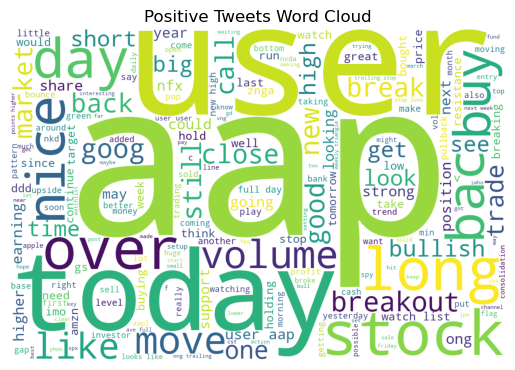

In [17]:
pos_wc = WordCloud(stopwords=stop_words, background_color='white', width=1080, height=720).generate(positive_corpus)
plt.axis('off')
plt.title('Positive Tweets Word Cloud')
plt.imshow(pos_wc)
plt.show()

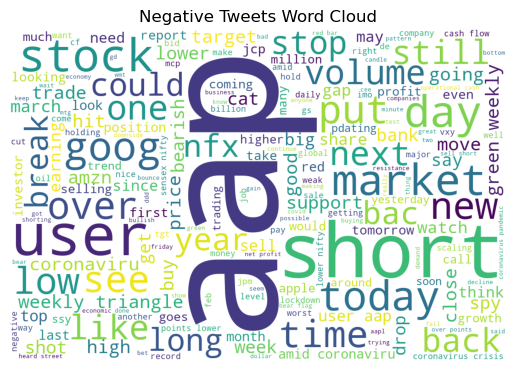

In [18]:
neg_wc = WordCloud(stopwords=stop_words, background_color='white', width=1080, height=720).generate(negative_corpus)
plt.axis('off')
plt.title('Negative Tweets Word Cloud')
plt.imshow(neg_wc)
plt.show()

The two words cloud do not appear to be particularly informative, as many words are shared between them. For example, words like 'user', 'aap', 'stock', 'today', 'volume' occur in a similar way in both negatice and positive tweets. A few things, however, can be noted:
- A relatively higher presence of the words 'long' and 'short' in positive and negative tweets, respectively. It can in fact be argued that 'going long' on an asset is an investment strategy occuring when that specific asset is performing well. In an opposite fashion, shorting a stock implies its poor performance.
- The stronger importance of the word 'market' in negative tweets may signal growing concerns regarding the market conditions. This could reflect the users' tendencies to associate the broader 'market' with negative events or trends. In a similar way, the occurrence of Google's stock in the negative word cloud could imply its weak returns  during the time period in which those tweets were written

It can be concluded that despite the word clouds share many common terms, there are subtle distinctions in the frequency of certain words that may prove to be useful for prediction tasks.

### Count of Unique Words

In [19]:
# check the most common words in the cleaned text column
word_counter = Counter(tweets_data['Cleaned Text'].sum())
print('Number of unique words:', len(word_counter))
print('Most common words:', word_counter.most_common(10))
print('Least common words:', word_counter.most_common()[-10:])
print()

# same thing only for positive tweets
positive_word_counter = Counter(positive_df['Cleaned Text'].sum())
print('Number of unique words in positive tweets:', len(positive_word_counter))
print('Most common words in positive tweets:', positive_word_counter.most_common(10))
print('Least common words in positive tweets:', positive_word_counter.most_common()[-10:])
print()

# same thing only for negative tweets
negative_word_counter = Counter(negative_df['Cleaned Text'].sum())
print('Number of unique words in negative tweets:', len(negative_word_counter))
print('Most common words in negative tweets:', negative_word_counter.most_common(10))
print('Least common words in negative tweets:', negative_word_counter.most_common()[-10:])


Number of unique words: 8254
Most common words: [('aap', 921), ('user', 645), ('short', 436), ('over', 347), ('today', 324), ('volume', 301), ('day', 293), ('like', 278), ('long', 256), ('good', 229)]
Least common words: [('nearl', 1), ('bse', 1), ('ended', 1), ('perilous', 1), ('ncd', 1), ('replace', 1), ('defensive', 1), ('cii', 1), ('wage', 1), ('factors', 1)]

Number of unique words in positive tweets: 6171
Most common words in positive tweets: [('aap', 514), ('user', 442), ('over', 254), ('today', 249), ('volume', 245), ('day', 213), ('long', 212), ('like', 190), ('good', 175), ('nice', 174)]
Least common words in positive tweets: [('nearl', 1), ('bse', 1), ('ended', 1), ('ncd', 1), ('replace', 1), ('rupee', 1), ('wage', 1), ('tests', 1), ('factors', 1), ('driving', 1)]

Number of unique words in negative tweets: 4643
Most common words in negative tweets: [('aap', 407), ('short', 351), ('user', 203), ('coronavirus', 129), ('over', 93), ('lower', 89), ('like', 88), ('day', 80), ('w

## Task 3

In this part of the analysis, we build a Neural Network that classifies tweets' sentiment as either 'positive' or 'negative'. The final aim is to have an accurate classifier that correctly predicts the sentiment of those tweets and use it to create a new factor.

We start with some simple preprocessing steps, such as tokenization and padding. Afterwords, we split the dataset in three sub-samples (train, validation, test) as we use the test dataset to measure the performance of out model.

### Tokenization

In [24]:
tokenizer = Tokenizer() # initialize the tokenizer
tokenizer.fit_on_texts(tweets_data['Cleaned Text'].values) # fit the tokenizer on the cleaned text column
tokenized_tweets = tokenizer.texts_to_sequences(tweets_data['Cleaned Text'].values) # tokenize the cleaned text column

### Padding

In [25]:
max_length = max([len(tweet) for tweet in tokenized_tweets]) # find the maximum length of the tokenized tweets
padded_sequences = pad_sequences(tokenized_tweets, maxlen=max_length, padding='post')  # pad the sequences to the maximum length

In [26]:
tweets_data['Padded Text'] = list(padded_sequences) # add the padded sequences to the dataframe

### Train Test Split

In [27]:
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, tweets_data['Sentiment'], test_size=0.1, random_state=42) # split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # split the training data into training and validation sets, to be used when training neural networks
print('Training set:', len(X_train))
print('Validation set:', len(X_val))
print('Testing set:', len(X_test))

Training set: 4168
Validation set: 1043
Testing set: 580


### Building Network

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, RNN, GRU
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential() # initialize the model
n_features = padded_sequences.shape[1] # number of features is the number of columns in the training data
model.add(Input(shape=(n_features,))) # add an input layer
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=16)) # add an embedding layer
model.add(Bidirectional(GRU(16))) # add a bidirectional LSTM layer
model.add(Dropout(0.8)) # add a dropout layer
model.add(Dense(1, activation='sigmoid')) # add an output layer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compile the model
model.summary() # print the model summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 22, 16)              │         132,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,377 (528.82 KB)

 Trainable params: 135,377 (528.82 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting

In [29]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True)] # initialize the early stopping callback to avoid overfitting
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=callbacks) # fit the model

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6314 - loss: 0.6686 - val_accuracy: 0.6194 - val_loss: 0.6558
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6457 - loss: 0.6323 - val_accuracy: 0.7315 - val_loss: 0.5446
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8019 - loss: 0.4580 - val_accuracy: 0.7756 - val_loss: 0.4751
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9085 - loss: 0.2750 - val_accuracy: 0.7728 - val_loss: 0.4909
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9358 - loss: 0.2103 - val_accuracy: 0.7795 - val_loss: 0.5817
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9524 - loss: 0.1588 - val_accuracy: 0.7718 - val_loss: 0.6445


### Evaluation

In [30]:
def predict_from_probability(probs, treshold):
    return np.where(probs >= treshold, 1, 0)

In [31]:
treshold = 0.5
print('TRAIN RESULTS:')
print(classification_report(y_train, predict_from_probability(model.predict(X_train), treshold))) # evaluate the model on the training data
print()
print('VALIDATION RESULTS:')
print(classification_report(y_val, predict_from_probability(model.predict(X_val), treshold))) # evaluate the model on the validation data
print()
print('TEST RESULTS:')
print(classification_report(y_test, predict_from_probability(model.predict(X_test), treshold))) # evaluate the model on the testing data

TRAIN RESULTS:
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1497
           1       0.95      0.92      0.94      2671

    accuracy                           0.92      4168
   macro avg       0.91      0.92      0.91      4168
weighted avg       0.92      0.92      0.92      4168


VALIDATION RESULTS:
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       397
           1       0.82      0.82      0.82       646

    accuracy                           0.78      1043
   macro avg       0.76      0.76      0.76      1043
weighted avg       0.78      0.78      0.78      1043


TEST RESULTS:
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       212
           1       0.83      0.82      0.82       368

    accurac

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The accuracy of the model is 77.76


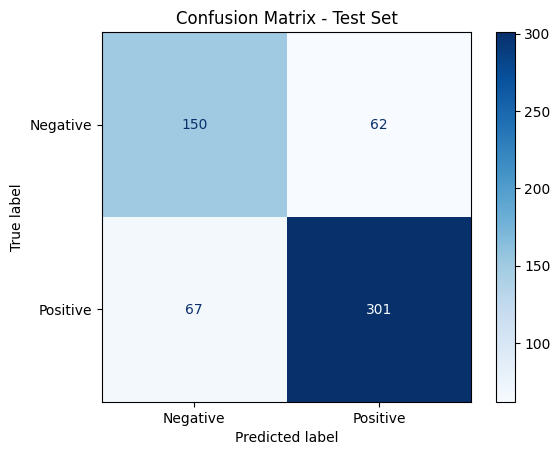

In [32]:
# Predict the probabilities for the test set
y_test_probs = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = predict_from_probability(y_test_probs, treshold)

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f'The accuracy of the model is {accuracy*100:.2f}')

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

The Bidirectional LSTM seems to have an accuracy of 77.76%. If we consider both the previously noted absence of a 'neutral' label, as well as the average short length of the tweets, it can be stated that the model performs well.

Our analysis can thus be extendd to alternative models, in an effort to identify the best one.



## Task 4

In [33]:
#!pip install tf-keras

NOTE THAT: in the cell below, the argument device=0 allows us to run the classifier on  GPU, which dramatically reduces the training time. This argument may cause errors. In that case, running the notebook on colab will solve the issue

In [34]:
classifier = pipeline("sentiment-analysis", model='distilbert/distilbert-base-uncased-finetuned-sst-2-english', device=0) # initialize the sentiment analysis pipeline
BERT_data = tweets_data.copy()
# apply the pipeline to the text column
BERT_data['BERT Sentiment'] = BERT_data['Text'].apply(lambda x: classifier(x)[0]['label'])
# convert the sentiment to a binary value
BERT_data['BERT Sentiment'] = BERT_data['BERT Sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)
# evaluate the pipeline
print('BERT RESULTS:')
display(BERT_data[['Text', 'Sentiment', 'BERT Sentiment']].head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


BERT RESULTS:


,Text,Sentiment,BERT Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,0
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,1
2,user I'd be afraid to short AMZN - they are lo...,1,0
3,MNTA Over 12.00,1,0
4,OI Over 21.37,1,0


In [35]:
BERT_data['BERT Sentiment'] = BERT_data['BERT Sentiment'].astype(int) # convert the score to an integer

The accuracy of the model is: 53.41 %


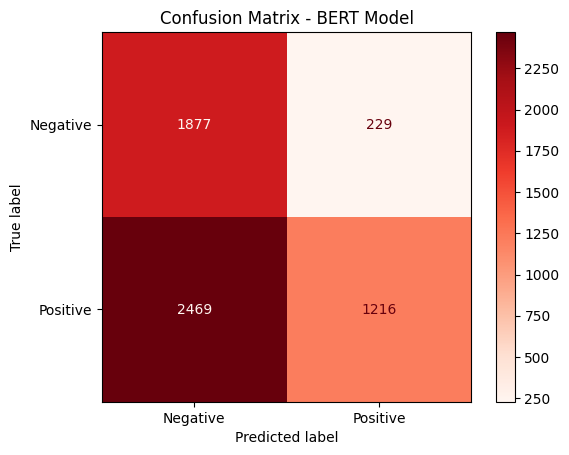

In [36]:
#print the accuracy of the model
print('The accuracy of the model is:', round(accuracy_score(BERT_data['Sentiment'], BERT_data['BERT Sentiment'])*100, 2), '%')

#confusion matrix for the BERT model
cm = confusion_matrix(BERT_data['Sentiment'], BERT_data['BERT Sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix - BERT Model')
plt.show()

The Confusion Matrix, which displays the prediction results of the BERT model and allows us to visualize the model accuracy, shows how a simple and pre-trained DistilBERT model does not perform well while conducting a sentiment analysis on financial tweets. More specifically, the model has an accuracy of 53.41%, which is significantly lower than that of the previously trained neural network.

Next, we will perform the classification task using finBERT.

### Optional - FinBERT

In [37]:
finBERT_classifier = pipeline('sentiment-analysis', model='ProsusAI/finbert', device=0)
finBERT_data = tweets_data.copy()
finBERT_data.loc[finBERT_data['Sentiment'] == 1, 'Sentiment'] = 2
# convert the text column to strings
finBERT_data['Text'] = finBERT_data['Text'].astype(str)
# apply the pipeline to the text column
finBERT_data['FinBERT Sentiment'] = finBERT_data['Text'].apply(lambda x: finBERT_classifier(x)[0]['label'])
# convert the sentiment to a binary value
finBERT_data['FinBERT Sentiment'] = finBERT_data['FinBERT Sentiment'].apply(lambda x: 2 if x == 'positive' else (1 if x == 'neutral' else 0))
# evaluate the pipeline
print('FinBERT RESULTS:')
display(finBERT_data[['Text', 'Sentiment', 'FinBERT Sentiment']].head())

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



FinBERT RESULTS:


,Text,Sentiment,FinBERT Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,2,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,2,1
2,user I'd be afraid to short AMZN - they are lo...,2,1
3,MNTA Over 12.00,2,1
4,OI Over 21.37,2,1


The accuracy of the model is: 29.34 %


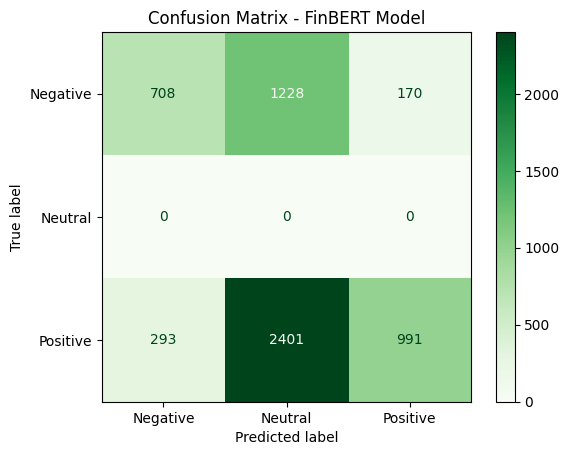

In [38]:
#print the accuracy of the model
print('The accuracy of the model is:', round(accuracy_score(finBERT_data['Sentiment'], finBERT_data['FinBERT Sentiment'])*100, 2), '%')

#confusion matrix for the finBERT model
cm = confusion_matrix(finBERT_data['Sentiment'], finBERT_data['FinBERT Sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - FinBERT Model')
plt.show()

The finBERT model technically performs better, since it has been pre-trained on financial data and it is capable of understanding specific financial words. However, its standard setup returns three labels ('Positive', 'Neutral' and 'Negative') instead of the two labels that characterize our initial dataset. In the next section, we will adapt the standard output of finBERT to a binary classification task. In simpler terms, we will remove the "neutral" label from possible outcomes.

### Optional - FinBERT with two labels

In this section, we impose the model to return the second highest score, in the case that the assigned label is "neutral". This way, the prediction will either be "positive" or "negative", depending on which of these two classes has the highest probability according to finBERT.

In [39]:
import torch

from transformers import Pipeline

class FinBERTPipeline_2(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "text" in kwargs:
            preprocess_kwargs["text"] = kwargs["text"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, sentence, maybe_arg=2):
        return self.tokenizer(sentence, return_tensors="pt")

    def _forward(self, inputs):
        return self.model(**inputs, output_hidden_states=True)

    def postprocess(self, outputs):
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction_max_index = int(torch.argmax(predictions))
        label = self.model.config.id2label[prediction_max_index]
        if label != 'neutral':
            return {'label': label, 'score': predictions[0][prediction_max_index].item()}
        else: # if the label is neutral, we return the second highest score
            predictions[0][prediction_max_index] = 0
            prediction_max_index = int(torch.argmax(predictions))
            label = self.model.config.id2label[prediction_max_index]
            return {'label': label, 'score': predictions[0][prediction_max_index].item()}

from transformers import pipeline
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import AutoModelForSequenceClassification

PIPELINE_REGISTRY.register_pipeline(
   'finbert-pipeline-with-two-labels',
   pipeline_class=FinBERTPipeline_2,
   pt_model=AutoModelForSequenceClassification,
)

finBERT_classifier_2 = pipeline('finbert-pipeline-with-two-labels', model='ProsusAI/finbert', device=0)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [40]:
finBERT_2_data = tweets_data.copy()
# convert the text column to strings
finBERT_2_data['Text'] = finBERT_2_data['Text'].astype(str)
# apply the pipeline to the text column
finBERT_2_data['FinBERT_2 Sentiment'] = finBERT_2_data['Text'].apply(lambda x: finBERT_classifier_2(x)['label'])
# convert the sentiment to a binary value
finBERT_2_data['FinBERT_2 Sentiment'] = finBERT_2_data['FinBERT_2 Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
# evaluate the pipeline
print('FinBERT_2 RESULTS:')
display(finBERT_2_data[['Text', 'Sentiment', 'FinBERT_2 Sentiment']].head())

FinBERT_2 RESULTS:


,Text,Sentiment,FinBERT_2 Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,0
2,user I'd be afraid to short AMZN - they are lo...,1,0
3,MNTA Over 12.00,1,1
4,OI Over 21.37,1,1


The accuracy of the model is: 69.75 %


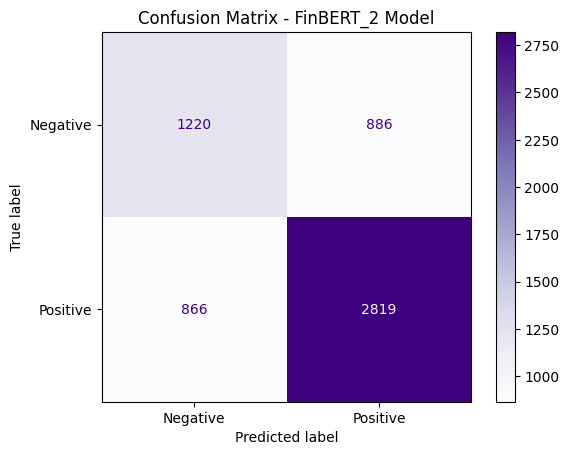

In [41]:
#print the accuracy of the model
print('The accuracy of the model is:', round(accuracy_score(finBERT_2_data['Sentiment'], finBERT_2_data['FinBERT_2 Sentiment'])*100, 2),'%')

#confusion matrix for the finBERT_2 model
cm = confusion_matrix(finBERT_2_data['Sentiment'], finBERT_2_data['FinBERT_2 Sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix - FinBERT_2 Model')
plt.show()

The modified finBERT model performs much better than the BERT model, with an accuracy 69.75%.



### Prediction task conclusions
After running the same prediction task on different model, we will compare their performances through their accuracy scores:
- Bidirectional LSTM (Neural Network): 77.76%
- BERT: 53.41%
- standard FinBERT: 29.34%
- modified FinBERT with 2 labels: 69.75%

It can therefore be concluded that the most efficient classifier for predicting a financial tweet's sentiment is the **Bidirectional LSTM**

# Task 5
As a last part of our analysis, we want to understand whether a stock's media attention is a good predictor of its performance. For this task, we will first rank all the scraped stocks by the number of times they are mentioned in the tweets. We will then compute the excess return of the 8 stocks we analyzed in the previous labs and plot them against each asset's media attention.

## Computing the media attention per stock

In [20]:
# we convert all of the tickers to lowercase, to compare them with the cleaned text column
wiki_tickers = [tic.lower() for tic in wiki_tickers]

In [21]:
tickers_tweet_count = pd.DataFrame(columns=['Ticker', 'Tweet Count', 'Positive Tweets', 'Negative Tweets']) # initialize the dataframe
# we do the same thing as above, but we use lambda functions to make the process more efficient
for tick in wiki_tickers: # iterate over the tickers
    tweet_count = tweets_data['Cleaned Text'].apply(lambda x: 1 if tick in x else 0).sum() # count the number of tweets that contain the ticker
    positive_tweets = tweets_data.apply(lambda x: 1 if tick in x['Cleaned Text'] and x['Sentiment'] == 1 else 0, axis=1).sum() # count the number of positive tweets that contain the ticker
    negative_tweets = tweets_data.apply(lambda x: 1 if tick in x['Cleaned Text'] and x['Sentiment'] == 0 else 0, axis=1).sum() # count the number of negative tweets that contain the ticker
    new_row = pd.DataFrame({'Ticker': [tick], 'Tweet Count': [tweet_count], 'Positive Tweets': [positive_tweets], 'Negative Tweets': [negative_tweets]})
    tickers_tweet_count = pd.concat([tickers_tweet_count, new_row], ignore_index=True) # append the results to the dataframe

tickers_tweet_count['Tweet Count'] = tickers_tweet_count['Tweet Count'].astype(int) # convert the tweet count to an integer
tickers_tweet_count['Positive Tweets'] = tickers_tweet_count['Positive Tweets'].astype(int) # convert the positive tweet count to an integer
tickers_tweet_count['Negative Tweets'] = tickers_tweet_count['Negative Tweets'].astype(int) # convert the negative tweet count to an integer
tickers_tweet_count['Ticker'] = tickers_tweet_count['Ticker'].str.upper() # convert back the tickers to uppercase

In [22]:
tickers_tweet_count #inspect the dataset

,Ticker,Tweet Count,Positive Tweets,Negative Tweets
0,MMM,3,2,1
1,AOS,1,0,1
2,ABT,8,6,2
3,ABBV,1,1,0
4,ACN,0,0,0
...,...,...,...,...
498,XYL,0,0,0
499,YUM,2,1,1
500,ZBRA,0,0,0
501,ZBH,0,0,0


In [23]:
# print the 'AAPL' row as an example
tickers_tweet_count[tickers_tweet_count['Ticker'] == 'AAPL']

,Ticker,Tweet Count,Positive Tweets,Negative Tweets
39,AAPL,45,28,17


In [24]:
# inspect the 10 most mentioned stocks in positive tweets
tickers_tweet_count.sort_values(by='Positive Tweets', ascending=False).head(10)


,Ticker,Tweet Count,Positive Tweets,Negative Tweets
140,DAY,279,204,75
57,BAC,201,152,49
20,GOOG,199,128,71
490,WELL,81,62,19
22,AMZN,108,60,48
476,V,53,48,5
222,GS,68,47,21
295,LOW,93,44,49
121,ED,62,43,19
110,C,50,41,9


In [25]:
# inspect the 10 most mentioned stocks in negative tweets
tickers_tweet_count.sort_values(by='Negative Tweets', ascending=False).head(10)

,Ticker,Tweet Count,Positive Tweets,Negative Tweets
140,DAY,279,204,75
20,GOOG,199,128,71
295,LOW,93,44,49
57,BAC,201,152,49
22,AMZN,108,60,48
90,CAT,53,12,41
142,DE,36,15,21
98,CF,34,13,21
222,GS,68,47,21
490,WELL,81,62,19


From the results it can be observed that the most discussed stocks produce very polarizing opinions, since they appear in both the negative and positive tweets rankings. Among those are included Amazon, Google, Bank of America and Goldman Sachs.

An issue to be noted with NLP-based sentiment analysis in this context is the potential for ticker symbols to be confused with common words. For example, "DAY" is not only a stock ticker but also a widely used word in regular language. As a result, the use of the word day in a temporal context may be misclassified as a reference to the stock itself.

## Comparing excess returns and media attention

#### Applying the CAPM
In this section we will use some of the functions and methods we developed for the previous Lab. 

In [26]:
stocks = pd.read_csv('Data_PCLab1_Stock.csv') # import the stock data
stocks['Date'] = pd.to_datetime(stocks['Date']) # convert the date column to datetime

stocks

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.130000,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.350000,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.250000,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.730000,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.800000,194.449997,180.520004,26.760000,318.590851,1314.500000
...,...,...,...,...,...,...,...,...,...,...
2154,2020-08-05,440.250000,174.279999,29.850000,16.719999,3205.030029,125.449997,1485.020020,1473.609985,3327.770020
2155,2020-08-06,455.609985,172.199997,29.840000,18.459999,3225.000000,126.120003,1489.579956,1500.099976,3349.159912
2156,2020-08-07,444.450012,170.020004,30.020000,19.030001,3167.459961,124.959999,1452.709961,1494.489990,3351.280029
2157,2020-08-10,450.910004,179.410004,30.200001,21.650000,3148.159912,127.110001,1418.569946,1496.099976,3360.469971


In [27]:
stock_tickers = [stock for stock in stocks.columns if stock != 'Date'] # save the stock tickers in a list
stock_tickers

['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG', 'sp500']

In [28]:
stock_names = ['Apple', 'Boeing', 'AT&T', 'MGM', 'Amazon', 'IBM', 'Tesla', 'Google', 'S&P500'] # save the stock names in a list

In [29]:
#we define a function that computes the daily returns of the stocks through the percentage change in price
def stocks_returns(data, stocks_tickers):
    data_returns = data.copy() # create a copy of the original dataset to avoid modifying it
    data_returns[stocks_tickers] = data_returns[stocks_tickers].apply(lambda x: x.pct_change()) #we apply the pct_change() method to each column
    return data_returns

stocks_ret = stocks_returns(stocks, stock_tickers) # compute the daily returns of the stocks
# we drop the first row, as it contains NaN values
data_returns = stocks_ret.dropna()
data_returns

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
1,2012-01-13,-0.003749,-0.012051,-0.001660,0.018137,0.014153,-0.007699,-0.193274,-0.007385,-0.004948
2,2012-01-17,0.011648,0.008579,0.005986,-0.008097,0.018159,0.004689,0.167179,0.005744,0.003553
3,2012-01-18,0.010384,-0.002392,0.002645,0.039184,0.042827,0.005944,0.007895,0.006889,0.011108
4,2012-01-19,-0.003169,0.006661,0.002967,0.005499,0.026446,-0.003038,-0.001865,0.010523,0.004939
5,2012-01-20,-0.017417,-0.000529,0.002959,-0.012500,-0.018102,0.044316,-0.005979,-0.083775,0.000669
...,...,...,...,...,...,...,...,...,...,...
2154,2020-08-05,0.003625,0.055794,-0.005332,0.000000,0.021091,-0.003099,-0.001332,0.005898,0.006430
2155,2020-08-06,0.034889,-0.011935,-0.000335,0.104067,0.006231,0.005341,0.003071,0.017976,0.006428
2156,2020-08-07,-0.024495,-0.012660,0.006032,0.030878,-0.017842,-0.009198,-0.024752,-0.003740,0.000633
2157,2020-08-10,0.014535,0.055229,0.005996,0.137677,-0.006093,0.017206,-0.023501,0.001077,0.002742


In [30]:
def capm(data, stock, risk_free_rate=0): # we define a function to fit the CAPM model
    data_capm = data.copy()
    X = data_capm['sp500'] - risk_free_rate # Market excess return
    X = sm.add_constant(X)  # Adds the intercept (alpha)
    y = data_capm[stock] - risk_free_rate # Stock excess return
    model = sm.OLS(y, X).fit() # Fit the model
    prediction = model.predict(X) # Get the predictions
    alpha, beta = model.params # Get the alpha and beta coefficients
    pvalue_alpha, pvalue_beta = model.pvalues # get p-values for alphas and betas

    return prediction, alpha, beta, pvalue_beta, pvalue_alpha

capm_predictions, capm_alphas, capm_betas, beta_pvalues, alpha_pvalues = [capm(data_returns, stock)[0] for stock in stock_tickers[:-1]], [capm(data_returns, stock)[1] for stock in stock_tickers[:-1]], [capm(data_returns, stock)[2] for stock in stock_tickers[:-1]], [capm(data_returns, stock)[3] for stock in stock_tickers[:-1]], [capm(data_returns, stock)[4] for stock in stock_tickers[:-1]]

# save the results in a dataframe to be used later
capm_coeff_df = pd.DataFrame({'Stock': stock_names[:-1], 'Stock Tickers' : stock_tickers[:-1], 'Betas': capm_betas, 'Alphas': capm_alphas, 'P-value Beta': beta_pvalues, 'P-value Alpha': alpha_pvalues}) # we create a dataframe with the results

In [31]:
def excess_return(data, stock, coeff, risk_free_rate=0): # prediction of the excess return of the equally weighted portfolio using betas and market returns from above
    data = data.copy()
    excess_return = risk_free_rate + coeff.loc[coeff['Stock Tickers'] == stock, 'Betas'].values[0] * (data['sp500'] - risk_free_rate) + coeff.loc[coeff['Stock Tickers'] == stock, 'Alphas'].values[0]
    return excess_return

# apply the prediction function to each stock and s<ve the results in a dictionary
excess_return_dictionary = {}
for stock in stock_tickers[:-1]:
    ex_ret = excess_return(data_returns, stock, capm_coeff_df)
    excess_return_dictionary[stock] = ex_ret.mean() * 252

In [32]:
excess_return_dictionary

{'AAPL': 0.27151840700527624,
 'BA': 0.1661620725265242,
 'T': 0.020569490427929757,
 'MGM': 0.1630238760035782,
 'AMZN': 0.3810048019682672,
 'IBM': -0.015356718215782208,
 'TSLA': 0.6010412173227071,
 'GOOG': 0.2127659432243307}

In [33]:
# convert the dictionary to a dataframe
excess_return_df = pd.DataFrame(excess_return_dictionary.items(), columns=['Stock', 'Excess Return'])

In [34]:
excess_return_df

,Stock,Excess Return
0,AAPL,0.271518
1,BA,0.166162
2,T,0.020569
3,MGM,0.163024
4,AMZN,0.381005
5,IBM,-0.015357
6,TSLA,0.601041
7,GOOG,0.212766


#### Comparison

In [35]:
excess_return_df = excess_return_df.merge(tickers_tweet_count, left_on='Stock', right_on='Ticker') # merge the excess return dataframe with the tweet count dataframe
excess_return_df = excess_return_df.drop(columns=['Ticker']) # drop the ticker column
excess_return_df.sort_values(by='Tweet Count', ascending=False, inplace=True) # sort the dataframe by tweet count
excess_return_df

,Stock,Excess Return,Tweet Count,Positive Tweets,Negative Tweets
7,GOOG,0.212766,199,128,71
4,AMZN,0.381005,108,60,48
0,AAPL,0.271518,45,28,17
5,IBM,-0.015357,21,15,6
3,MGM,0.163024,12,8,4
1,BA,0.166162,9,4,5
6,TSLA,0.601041,2,2,0
2,T,0.020569,0,0,0


In [36]:
# histogram with the excess return of the stocks
fig = px.bar(excess_return_df, x='Stock', y='Excess Return', color='Tweet Count', title='Excess Return of Stocks')
fig.update_layout(xaxis_title='Stock', yaxis_title='Excess Return', coloraxis_colorbar_title='Tweet Count')
fig.show()

In [37]:
# scatter plot of the excess return and the tweet count
fig = px.scatter(excess_return_df, x='Tweet Count', y='Excess Return', color='Stock', size=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], title='Excess Return vs Tweet Count')
fig.update_layout(xaxis_title='Tweet Count', yaxis_title='Excess Return', coloraxis_colorbar_title='Stock')
fig.show()

As it can be observed from the previous two plots, there seems to be no clear pattern of correlation between media attention and excess return of an individual stock. The number of tweets in which a stock is mentioned thus should not be used as a factor.

Logically speaking, the media's attention to a particular stock is simply correlated to its performance. In simpler terms, it is more likely to talk negatively (positively) of a stock if it is already performing bad (well). Therefore, inferring a causal relationship between media attention and assets' excess returns is a very difficult, if not impossible, task.
